In [ ]:
#| default_exp tid2013

# Loading TID2013

> Loading TID2013 from our private server.

In [ ]:
#| export
import re

import pandas as pd
from pathlib import Path
from natsort import natsorted
from fastcore.foundation import L

TID2013 is already present on our server, but one may find it a little bit confusing to load: there is a `mos_with_names.txt` file that connects each distorted image with its MOS, the reference images are in the `reference_images` foldes, and the distorted images are in the `distorted_images` folder. This means that we will have to load both folders and connect the corresponding images with the `mos_with_names.txt` file.

Another important thing to note is that each distorted image is named in a meaningful way: `I(img_id)_(dist_id)_(dist_int).bmp`, so we may use that information at our discretion. Leaving complicated filterings aside, we can start by loading all the images and connecting them.

In [ ]:
#| hide
path_root = Path("/media/disk/databases/BBDD_video_image/Image_Quality/TID/TID2013/")
path_txt = path_root/"mos_with_names.txt"
path_ref = path_root/"reference_images"
path_dist = path_root/"distorted_images"

Following the usual approach, we are going to try to build a `.csv` file relating each reference image, its distortions and the corresponding MOS. By doing so, we reduce a lot the possible complications when loading the data because it will be all paired. The idea is that we are going to fetch all the image paths and then will pair them using the `.txt` files:

In [ ]:
df = pd.read_csv(path_txt, header=None, sep=" ", names=["MOS", "Distorted"])
df.head()

,MOS,Distorted
0,5.51429,I01_01_1.bmp
1,5.56757,i01_01_2.bmp
2,4.94444,i01_01_3.bmp
3,4.37838,i01_01_4.bmp
4,3.86486,i01_01_5.bmp


:::{callout-warning}

We have found some paths of the distortion images that are in uppercase, but all the filenames are set in lowercase. To avoid any potential issues we will lowercase them all just in case.

:::

In [ ]:
df['Distorted'] = df.Distorted.apply(lambda x: x.lower())
df.head()

,MOS,Distorted
0,5.51429,i01_01_1.bmp
1,5.56757,i01_01_2.bmp
2,4.94444,i01_01_3.bmp
3,4.37838,i01_01_4.bmp
4,3.86486,i01_01_5.bmp


To avoid unnecessary hustle, we can a column to our dataframe that points to the corresponding `reference_image` and we should be good to go. Keep in mind that, as we should be expecting this far in, reference images are all in uppercase format (extension included), so we'll have to adjust consequently.

In [ ]:
#| exporti
def get_ref_name(dist_name):
    file, extension = re.search(r"(.+)_\d+_\d+\.(.+)", dist_name).groups()
    return ".".join((file, extension)).upper()

In [ ]:
a = "I01_01_1.bmp"
assert get_ref_name(a) == 'I01.BMP'

In [ ]:
df['Reference'] = df.Distorted.apply(get_ref_name)
df.head()

,MOS,Distorted,Reference
0,5.51429,i01_01_1.bmp,I01.BMP
1,5.56757,i01_01_2.bmp,I01.BMP
2,4.94444,i01_01_3.bmp,I01.BMP
3,4.37838,i01_01_4.bmp,I01.BMP
4,3.86486,i01_01_5.bmp,I01.BMP


Finally, check that we can load the images properly with the dataframe:

In [ ]:
from PIL import Image

In [ ]:
for i, row in df.iterrows():
    img = Image.open(str(path_ref/row.Reference))
    dist = Image.open(str(path_dist/row.Distorted))
print("All images could be loaded without issues!")

All images could be loaded without issues!


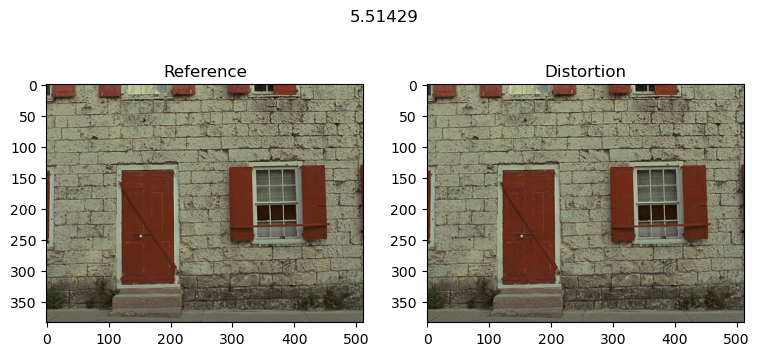

In [ ]:
#| notest
import matplotlib.pyplot as plt
for i, row in df.iterrows():
    img = Image.open(str(path_ref/row.Reference))
    dist = Image.open(str(path_dist/row.Distorted))
    break
fig, axes = plt.subplots(1,2,figsize=(9,4))
axes[0].imshow(img)
axes[0].set_title("Reference")
axes[1].imshow(dist)
axes[1].set_title("Distortion")
plt.suptitle(row.MOS)
plt.show()

Just before saving the file, we will reorder and rename the columns to match the other datasets:

In [ ]:
df = df.reindex(columns=["Reference", "Distorted", "MOS"])
df.head()

,Reference,Distorted,MOS
0,I01.BMP,i01_01_1.bmp,5.51429
1,I01.BMP,i01_01_2.bmp,5.56757
2,I01.BMP,i01_01_3.bmp,4.94444
3,I01.BMP,i01_01_4.bmp,4.37838
4,I01.BMP,i01_01_5.bmp,3.86486


## Adding extra information

> In order to be able to filter our data by distortion or intensity, we can explicify this information in new columns to ease the process.

In [ ]:
df["Reference_ID"] = df.Reference.apply(lambda x: re.search(r"I(\d+).BMP", x).group(1))
assert len(df.Reference_ID.unique()) == 25
df.head()

,Reference,Distorted,MOS,Reference_ID
0,I01.BMP,i01_01_1.bmp,5.51429,01
1,I01.BMP,i01_01_2.bmp,5.56757,01
2,I01.BMP,i01_01_3.bmp,4.94444,01
3,I01.BMP,i01_01_4.bmp,4.37838,01
4,I01.BMP,i01_01_5.bmp,3.86486,01


In [ ]:
df["Distortion_ID"] = df.Distorted.apply(lambda x: x.split("_")[1])
assert len(df.Distortion_ID.unique()) == 24
df.head()

,Reference,Distorted,MOS,Reference_ID,Distortion_ID
0,I01.BMP,i01_01_1.bmp,5.51429,01,01
1,I01.BMP,i01_01_2.bmp,5.56757,01,01
2,I01.BMP,i01_01_3.bmp,4.94444,01,01
3,I01.BMP,i01_01_4.bmp,4.37838,01,01
4,I01.BMP,i01_01_5.bmp,3.86486,01,01


In [ ]:
df["Distortion_Intensity"] = df.Distorted.apply(lambda x: x.split("_")[2].split(".")[0])
assert len(df.Distortion_Intensity.unique()) == 5
df.head()

,Reference,Distorted,MOS,Reference_ID,Distortion_ID,Distortion_Intensity
0,I01.BMP,i01_01_1.bmp,5.51429,01,01,1
1,I01.BMP,i01_01_2.bmp,5.56757,01,01,2
2,I01.BMP,i01_01_3.bmp,4.94444,01,01,3
3,I01.BMP,i01_01_4.bmp,4.37838,01,01,4
4,I01.BMP,i01_01_5.bmp,3.86486,01,01,5


In [ ]:
#| notest
# df.to_csv(path_root/"image_pairs_mos.csv")

In [ ]:
exclude_imgs = ["14", "15"]

In [ ]:
df[~df.Reference_ID.isin(exclude_imgs)]

,Reference,Distorted,MOS,Reference_ID,Distortion_ID,Distortion_Intensity
0,I01.BMP,i01_01_1.bmp,5.51429,01,01,1
1,I01.BMP,i01_01_2.bmp,5.56757,01,01,2
2,I01.BMP,i01_01_3.bmp,4.94444,01,01,3
3,I01.BMP,i01_01_4.bmp,4.37838,01,01,4
4,I01.BMP,i01_01_5.bmp,3.86486,01,01,5
...,...,...,...,...,...,...
2995,I25.BMP,i25_24_1.bmp,5.65714,25,24,1
2996,I25.BMP,i25_24_2.bmp,5.44444,25,24,2
2997,I25.BMP,i25_24_3.bmp,4.62857,25,24,3
2998,I25.BMP,i25_24_4.bmp,4.02778,25,24,4
